In [1]:
import utils

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm

import nltk
#nltk.download('wordnet')
#nltk.download('stopwords')
from nltk.corpus import stopwords

import numpy as np

import sklearn.model_selection

import torch

from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout
import keras

import pydot

import matplotlib.pyplot as plt

Using TensorFlow backend.


# Análisis de sentimientos

In [2]:
stop_words = set(stopwords.words('english'))

## Datos

El conjunto de datos se compone de archivos separados por tabulaciones con frases del conjunto de datos de Rotten Tomatoes. La división de train/test se ha conservado con fines de evaluación comparativa, pero las oraciones se han barajado de su orden original. Cada oración ha sido analizada en muchas frases por el analizador Stanford. Cada frase tiene un PhraseId. Cada oración tiene un SentenceId. Las frases que se repiten (como palabras cortas / comunes) solo se incluyen una vez en los datos.

     train.tsv contiene las frases y sus etiquetas de sentimiento asociadas. También hemos proporcionado un SentenceId para que pueda rastrear qué frases pertenecen a una sola oración.
     test.tsv contiene solo frases. Debe asignar una etiqueta de sentimiento a cada frase.

Conjunto        | TAMAÑO    | 
----------------|-----------|
Entrenamiento   | 156060    |
Prueba          |  66292    |

ETIQUETA | SENTIMIENTO |
---------|-------------|
0        | negativo    |
1        |algo negativo|
2        | neutral     |
3        |algo positivo|
4        | positivo    |

Información del conjunto de entrenamiento

SENTIMIENTO|  NUM. REVIEWS  |
-----------|----------------|
0          |     7072       |
1          |     27273      |
2          |     79582      |
3          |     32927      |
4          |     9206       |
*          |     156060     |


### Exploración de los datos

In [3]:
# cargar los archivos de los datos
df_train = pd.read_csv('DATA/train.tsv', sep="\t")
df_test = pd.read_csv("DATA/test.tsv", sep="\t")

In [4]:
print("Tamaño del conjunto de entrenamiento: ", df_train.shape[0])
print("Tamaño del conjunto de pruebas: ", df_train.shape[0])

Tamaño del conjunto de entrenamiento:  156060
Tamaño del conjunto de pruebas:  156060


In [5]:
df_train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


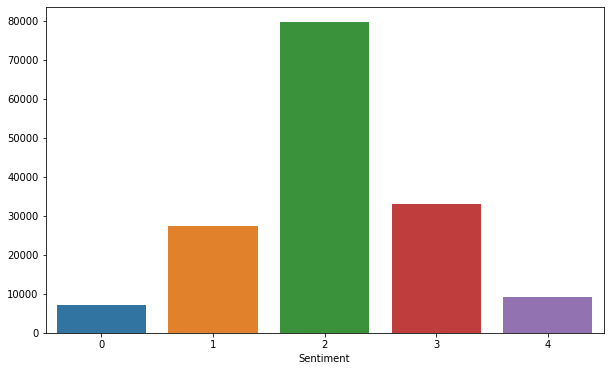

In [6]:
distribucion = df_train.groupby(["Sentiment"]).size() # resume en tercera tabla

fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(distribucion.keys(), distribucion.values);
#sns.distplot(distribucion.values, fit=norm, kde=False)

### Pre-procesamiento de los datos

Las palabras deben ser tokenizadas en formato numérico para pasar a RNN.

Filtrar espacios y signos de puntuación.

Lematizar para reducir aún más la dimensionalidad.

Eliminar stop-words.

El siguiente paso es convertir palabras en vectores de números.

In [11]:
# crear una bolsa de palabras para codificar las frases a vectores
bag_words = set()
for phrase in df_train['Words']:
    for word in phrase:
        bag_words.add(word)
        

print(len(bag_words))

16209
16209
['insouciance', 'fully', 'scruffy', 'clear', 'prosaic', 'sleekness', 'heist', 'clockstoppers', 'creations', 'transvestite']
[('insouciance', 1), ('fully', 2), ('scruffy', 3), ('clear', 4), ('prosaic', 5), ('sleekness', 6), ('heist', 7), ('clockstoppers', 8), ('creations', 9), ('transvestite', 10)]


Ahora, como las redes neuronales deben de tener una logitud igual para cada entrada, entonces completamos los vectores con 0's para que tengan la logitud del vector mayor longitud.

In [14]:
# Pasar a datos categoricos las clases

Y = np.array([l for l in df_train['Sentiment']])
Y = keras.utils.np_utils.to_categorical(Y)

# NUMERO DE CLASES
num_class = Y.shape[1]

[[11173 15038  7745 14358  7095  9682  7309   901  6627  8350  9722 12389
   9682  7733  8350 14410  9722 12389  9682 11415  6446  7745 14782 11776
    712  3161  1938  7745 14782  7772 10121  4083  7745 11173 11146     0
      0     0     0     0     0     0     0     0     0     0     0     0]
 [11173 15038  7745 14358  7095  9682  7309   901  6627  8350  9722 12389
   9682  7733     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0]
 [11173 15038     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0]]
Dimension de la matriz de datos:  (156060, 48)


In [32]:
"""
    Convertir cada enunciado a representación de vectores 
        para la entrada de la red neuronal
"""
tokenizer = keras.preprocessing.text.Tokenizer(num_words=len(list(bag_words)))
tokenizer.fit_on_texts(list(df_train['Phrase']))


X_p = tokenizer.texts_to_sequences(df_train['Phrase'])

#padding done to equalize the lengths of all input reviews. LSTM networks needs all inputs to be same length.
#Therefore reviews lesser than max length will be made equal using extra zeros at end. This is padding.

X_p = keras.preprocessing.sequence.pad_sequences(X_p, maxlen=max_len)

#### Dividir los datos para entrenamiento, validación y prueba

Para este trabajo, se propone el 80% para entrenamiento y el 20% restante para prueba.

In [33]:

# utilizando la funcion de keras
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X_p,Y, test_size = .2 , random_state = 42)

print("\t\t\tDimesiones datos: \t\t\tDimensiones etiquetas")
print("Train set: \t\t{}".format(X_train.shape),
      "\nTest set: \t\t{}".format(X_test.shape))

			Dimesiones datos: 			Dimensiones etiquetas
Train set: 		(124848, 48) 
Test set: 		(31212, 48)


In [16]:
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(124848, 48) (124848, 5)
(31212, 48) (31212, 5)


## Modelo de red profunda

1) Primero, pasaremos las palabras a una capa de incrustación. Necesitamos una capa de incrustación porque tenemos miles de palabras, por lo que necesitaremos una representación más eficiente para nuestros datos de entrada que los vectores codificados en caliente. En este caso, la capa de inclusión es para la reducción de la dimensionalidad, en lugar de para aprender representaciones semánticas.


In [17]:
# First checking if GPU is available
gpu=torch.cuda.is_available()

if(gpu):
    print('Disponible.')
else:
    print('No disponible.')

Disponible.


In [34]:
model=Sequential()

model.add(Embedding(len(list(bag_words)),300,input_length=max_len))

model.add(LSTM(128,dropout=0.5, recurrent_dropout=0.5,return_sequences=True))

model.add(LSTM(64,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))

model.add(Dense(100,activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(num_class,activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 48, 300)           4862700   
_________________________________________________________________
lstm_3 (LSTM)                (None, 48, 128)           219648    
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               6500      
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 505       
Total params: 5,138,761
Trainable params: 5,138,761
Non-trainable params: 0
____________________________________________

In [35]:
# Estructura
#keras.utils.plot_model(model, 'model.png')

In [36]:
batch_size = 256
historia = model.fit(X_train, Y_train, validation_split=0.20,epochs = 6, batch_size=batch_size, verbose = 2)

Train on 99878 samples, validate on 24970 samples
Epoch 1/6
 - 150s - loss: 1.1703 - accuracy: 0.5397 - val_loss: 0.9916 - val_accuracy: 0.6108
Epoch 2/6
 - 151s - loss: 0.9073 - accuracy: 0.6403 - val_loss: 0.8669 - val_accuracy: 0.6491
Epoch 3/6
 - 158s - loss: 0.8079 - accuracy: 0.6747 - val_loss: 0.8423 - val_accuracy: 0.6531
Epoch 4/6
 - 160s - loss: 0.7574 - accuracy: 0.6939 - val_loss: 0.8389 - val_accuracy: 0.6580
Epoch 5/6
 - 160s - loss: 0.7220 - accuracy: 0.7042 - val_loss: 0.8366 - val_accuracy: 0.6558
Epoch 6/6
 - 155s - loss: 0.6931 - accuracy: 0.7143 - val_loss: 0.8435 - val_accuracy: 0.6592


## Visualizar la curva de aprendizaje

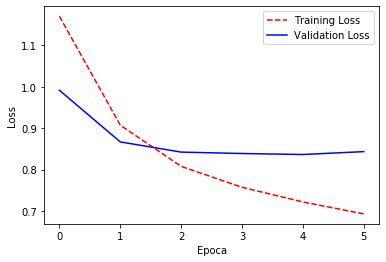

In [37]:
# crear lista del numero de epocas realizadas
num_epocas = range(1, len(historia.history['loss']) + 1)

plt.plot(historia.history['loss'], 'r--')
plt.plot(historia.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.show()